In [1]:
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import loompy
from Bio import Phylo
import phylovelo as pv
from matplotlib import font_manager
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
plt.rcParams['font.size'] = 12

In [3]:
data_path = '/data3/wangkun/phylovelo_datasets/jh/'

In [4]:
adata = scv.read(data_path + 'combined.loom', cache=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
datatable = pd.read_csv(data_path + 'Supplementary_File_2_DataTableMOI19.csv', index_col=0)

In [6]:
tree = Phylo.read(data_path+'tr.nwk', format='newick')

In [7]:
selected_cells = [i.name.replace('-1',"x") for i in tree.get_terminals()]
cells_SRR18280236 = ["SRR18280236:"+i for i in selected_cells]
selected_cells_SRR18280236 = list(set(cells_SRR18280236).intersection(set(adata.obs.index.to_list())))
unselected_cells_SRR18280236 = list(set(cells_SRR18280236).difference(set(selected_cells_SRR18280236)))


cells_SRR18280237 = [cell.replace("SRR18280236","SRR18280237") for cell in unselected_cells_SRR18280236]
selected_cells_SRR18280237 = list(set(cells_SRR18280237).intersection(set(adata.obs.index.to_list()))) 

selected_cells = selected_cells_SRR18280236 + selected_cells_SRR18280237
selected_cells.sort()

In [8]:
adata = adata[selected_cells,]
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 29903 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/160 cores)


  0%|          | 0/57 [00:00<?, ?gene/s]

    finished (0:00:20) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/160 cores)


  0%|          | 0/3248 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


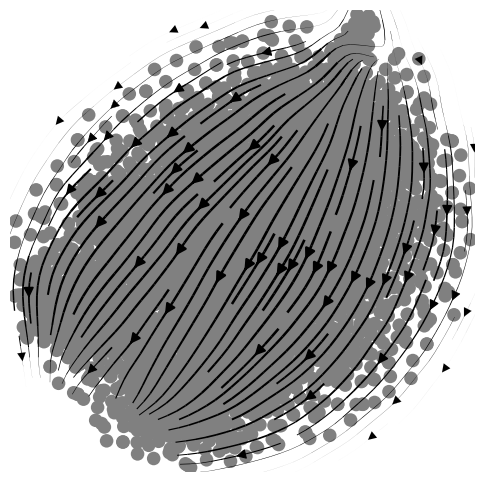

In [9]:
scv.pp.filter_and_normalize(adata,min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata,n_pcs=30, n_neighbors=30)  
# scv.tl.louvain(adata)
scv.tl.tsne(adata)
scv.tl.recover_dynamics(adata,n_jobs=1)
scv.tl.velocity(adata,mode="dynamical")
scv.tl.velocity_graph(adata,n_jobs=1)
scv.pl.velocity_embedding_stream(adata, basis='X_tsne',figsize=[6,6],s=380,alpha=1,density=1.5,arrow_size=1.5,
                               smooth=1,legend_fontsize=0,legend_loc=None)

In [10]:
scv.tl.latent_time(adata)

computing terminal states
    identified 4 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [11]:
sd = pv.scData()
sd.phylo_tree = tree
adata1 = scv.read(data_path + 'combined.loom', cache=False)
adata1 = adata1[selected_cells,]
adata1.var_names_make_unique()
sd.count = pd.DataFrame(data=adata1.X.A, index=adata1.obs_names, columns=adata1.var_names)
scv.pp.filter_and_normalize(adata1,min_shared_counts=20)
sd.x_normed = pd.DataFrame(data=adata1.X.A, index=adata1.obs_names, columns=adata1.var_names)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 29903 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [12]:
sd.cell_names = sd.x_normed.index
sd.Xdr = pd.DataFrame(data=adata.obsm['X_tsne'], index=adata.obs_names)
sd.Xdr = sd.Xdr.loc[sd.cell_names]

In [13]:
mutnum = [(~pd.isnull(datatable.loc[i[12:].replace('x', '-1')].iloc[:,1:6])).sum().sum() for i in sd.x_normed.index]

In [14]:
pv.velocity_inference(sd, mutnum, target='x_normed')
pv.velocity_embedding(sd, target='x_normed')
pv.calc_phylo_pseudotime(sd, 30, 0.3)

  0%|          | 0/6698 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/973 [00:00<?, ?it/s]

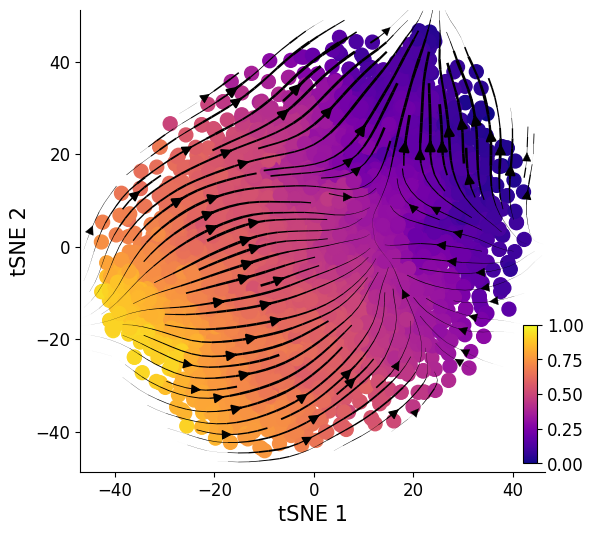

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], s=100, c=sd.phylo_pseudotime,cmap='plasma')
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream', grid_density=25, radius=5, lw_coef=7000, arrowsize=1.5)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('./figures/fig6/hek293_phylovelo.pdf', dpi='figure', format='pdf')

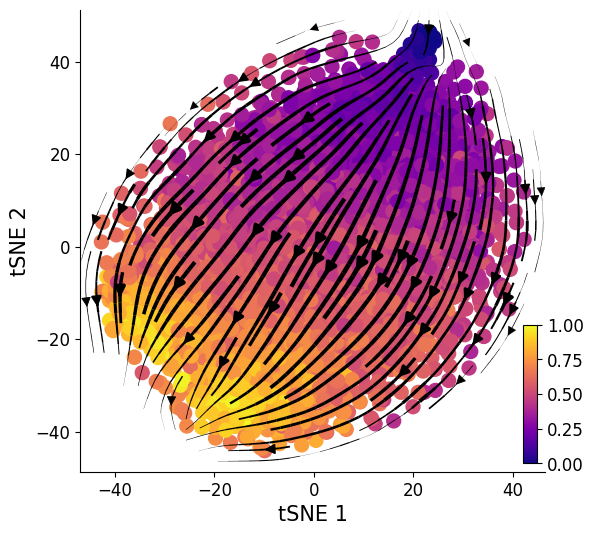

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
scatter=ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], s=100, c=adata.obs['latent_time'],cmap='plasma')
ax = pv.velocity_plot(sd.Xdr.to_numpy(), adata.obsm['velocity_tsne'], ax, 'stream', grid_density=25, radius=5, lw_coef=4, arrowsize=1.5)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('./figures/fig6/hek293_scv.pdf', dpi='figure', format='pdf')

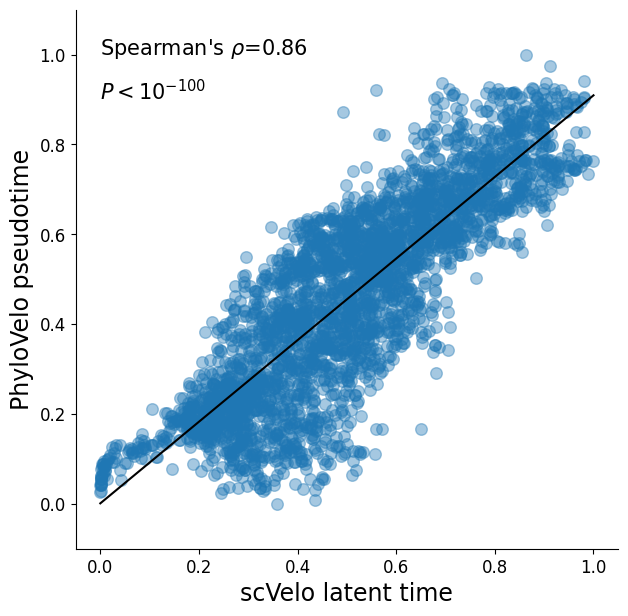

In [18]:
from scipy.stats import spearmanr
x = adata.obs['latent_time']
y = sd.phylo_pseudotime

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(0,1,60) + b

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(0,1,60), y_est, '-', c='k')
ax.set_xlabel('scVelo latent time', fontsize=17)
ax.set_ylabel('PhyloVelo pseudotime', fontsize=17)
rho, pval = spearmanr(x, y)
ax.text(0, 1, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
# ax.text(0, 0.9, r'$P$={}'.format(pval), fontsize=15)
ax.text(0, 0.9, r'$P<10^{-100}$', fontsize=15)
# ax.text(0.7, 0.05, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
ax.set_ylim(-0.1,1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [26]:
v_megs = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns, columns=['velocity']).loc[sd.megs]
v_megs['p_value']=sd.pvals.T
v_megs['q_value']=sd.qvals.T
v_megs.to_csv('./megs/hek293t.csv')

In [41]:
import scanpy as sc
import anndata as ad

adata_gs = ad.AnnData(sd.count)
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2','USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']
g2m_genes= ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
sc.tl.score_genes_cell_cycle(adata_gs, s_genes=s_genes, g2m_genes=g2m_genes)

In [44]:
sc.pp.filter_genes(adata_gs, min_counts=20)
sc.pp.normalize_total(adata_gs, inplace=True)
sc.pp.log1p(adata_gs)

In [48]:
sc.pp.regress_out(adata_gs, ['S_score', 'G2M_score'])
sc.tl.pca(adata_gs)
sc.tl.tsne(adata_gs)

... storing 'phase' as categorical


In [51]:
sd_regcc = pv.scData(x_normed=pd.DataFrame(adata_gs.X, index=adata_gs.obs_names, columns=adata_gs.var_names),
                      Xdr=pd.DataFrame(adata_gs.obsm['X_tsne'],index=adata_gs.obs_names)
                     )

In [59]:
pv.velocity_inference(sd_regcc, mutnum, cutoff=0.97, target='x_normed')
pv.velocity_embedding(sd_regcc, target='x_normed')
pv.calc_phylo_pseudotime(sd_regcc, 30, 0.3)

  0%|          | 0/11804 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/973 [00:00<?, ?it/s]

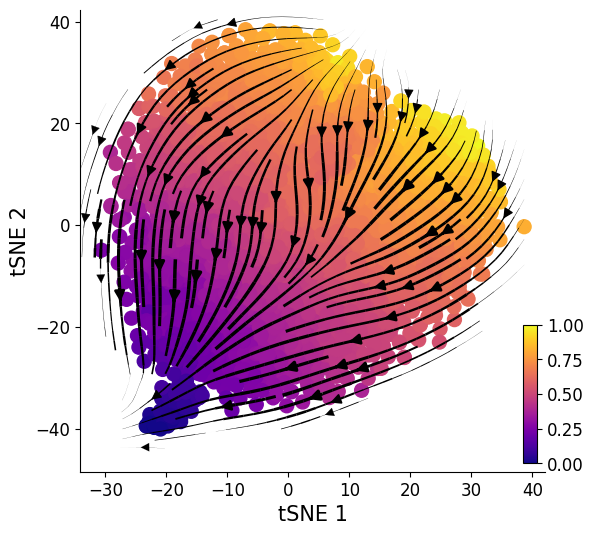

In [60]:
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(sd_regcc.Xdr.iloc[:, 0], sd_regcc.Xdr.iloc[:, 1], s=100, c=sd_regcc.phylo_pseudotime,cmap='plasma')
ax = pv.velocity_plot(sd_regcc.Xdr.to_numpy(), sd_regcc.velocity_embeded, ax, 'stream', grid_density=25, radius=5, lw_coef=7000, arrowsize=1.5)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('./figures/fig6/hek293_phylovelo.pdf', dpi='figure', format='pdf')

In [62]:
import pickle
pickle.dump(sd_regcc, open('/data3/wangkun/result_sd/hek293t_regressout_ccgenes.pkl', 'wb'))

<AxesSubplot: >

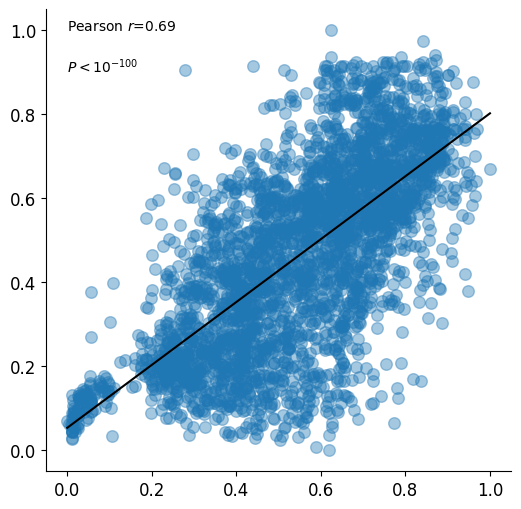

In [61]:
fig, ax = plt.subplots(figsize=(6,6))
pv.corr_plot(sd_regcc.phylo_pseudotime, sd.phylo_pseudotime, ax)

Text(0, 0.5, 'G2M score')

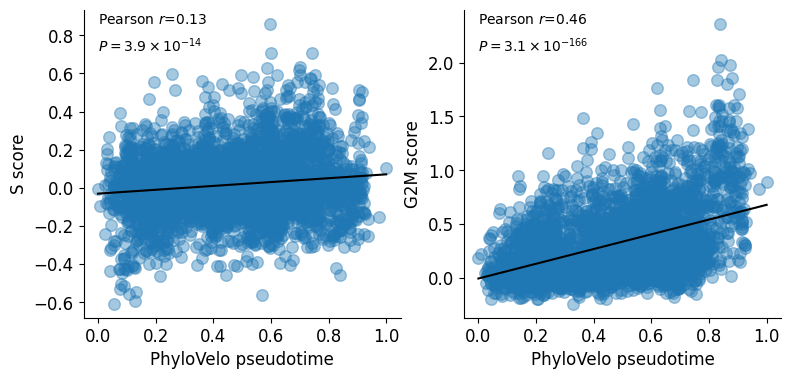

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))
corr_plot(sd.phylo_pseudotime, adata_gs[sd.count.index].obs['S_score'], ax[0])
corr_plot(sd.phylo_pseudotime, adata_gs[sd.count.index].obs['G2M_score'], ax[1])
ax[1].set_xlabel('PhyloVelo pseudotime')
ax[0].set_xlabel('PhyloVelo pseudotime')
ax[0].set_ylabel('S score')
ax[1].set_ylabel('G2M score')

Text(0, 0.5, 'G2M score')

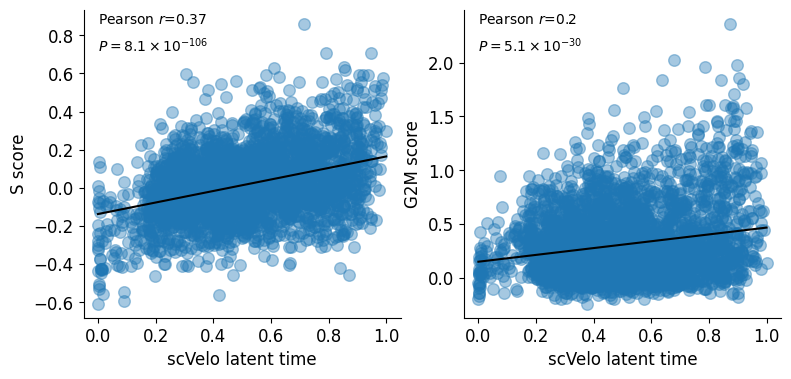

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))
corr_plot(adata[sd.count.index].obs['latent_time'], adata_gs[sd.count.index].obs['S_score'], ax[0])
corr_plot(adata[sd.count.index].obs['latent_time'], adata_gs[sd.count.index].obs['G2M_score'], ax[1])
ax[1].set_xlabel('scVelo latent time')
ax[0].set_xlabel('scVelo latent time')
ax[0].set_ylabel('S score')
ax[1].set_ylabel('G2M score')

In [260]:
ctscore = pd.read_csv('/home/wangkun/HEK293T_cytotrace.csv', index_col=0)
ctscore.index = [i.replace('.', ':') for i in ctscore.index]

In [261]:
ctscore = ctscore.loc[sd.count.index] 

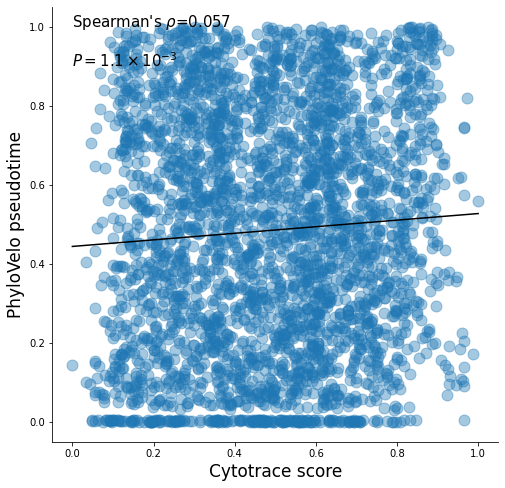

In [274]:
# plt.scatter(sd.phylo_pseudotime, sd.count.sum(axis=1))
x = sd.phylo_pseudotime
# y = np.array(adata_raw[sd.x_normed.index].X.sum(axis=1)).flatten()
y = ctscore['x']

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=120)
ax.plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
ax.set_ylabel('PhyloVelo pseudotime', fontsize=17)
ax.set_xlabel('Cytotrace score', fontsize=17)
# ax.set_title('kp3435 normalize', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.95, r"Spearman's $\rho$={:.2g}\n$P$={:.2g}".format(*spearmanr(x, y)), fontsize=15) 
rho, pval = spearmanr(x, y)

ax.text(min(x)*1.1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
if pval:
    # ax.text(min(x)*1.1, max(y)*0.9, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
    ax.text(min(x)*1.1, max(y)*0.9, r'$P=1.1\times10^{-3}$', fontsize=15)
else:
    ax.text(min(x)*1.1, max(y)*0.9, r'$P<10^{-100}$', fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [42]:
corrs = []
genelist = []
for i in list(sd.x_normed):
    genelist.append(i)
    x = np.array(mutnum)
    y = sd.x_normed[i]
    corrs.append(spearmanr(x,y)[0])
corrs = np.array(corrs)
genelist = np.array(genelist)

genes1 = genelist[corrs>0]
genes2 = genelist[corrs<0]

Text(0.04, 0.5, 'Total normalized UMI of MEGs')

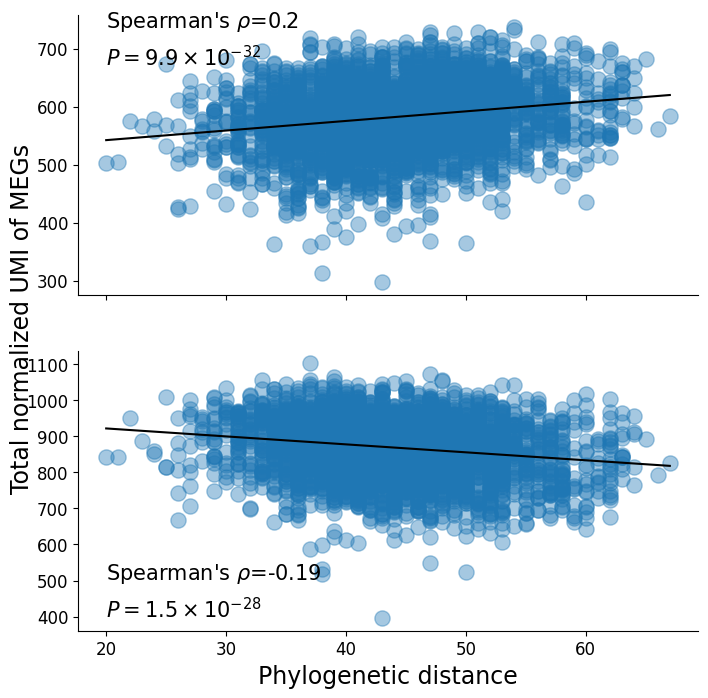

In [43]:
# genes1 = sd.x_normed.columns[sd.velocity>0]
# genes2 = sd.x_normed.columns[sd.velocity<0]


x = mutnum
y = sd.x_normed[genes1].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b

fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax[0].scatter(x, y, alpha=0.4, s=120)
ax[0].plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
# ax[0].set_ylabel('Total normalized UMI of MEGs', fontsize=17)
# ax[0].set_xlabel('Phylogenetic distance', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.85, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)

ax[0].text(min(x)*1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax[0].text(min(x)*1, max(y)-(max(y)-min(y))*0.15, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

# ax.text(min(x)*1.1, min(y)*1.05, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
# ax.text(min(x)*1.1, min(y)*1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


x = mutnum
y = sd.x_normed[genes2].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b


ax[1].scatter(x, y, alpha=0.4, s=120)
ax[1].plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
# ax[1].set_ylabel('Total normalized UMI of MEGs', fontsize=17)
ax[1].set_xlabel('Phylogenetic distance', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.85, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)

ax[1].text(min(x)*1, min(y)+(max(y)-min(y))*0.15, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax[1].text(min(x)*1, min(y)*1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

fig.text(0.04, 0.5, 'Total normalized UMI of MEGs', va='center', rotation='vertical',fontsize=17)

In [54]:
v_megs = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns, columns=['velocity']).loc[sd.megs]
v_megs['p_value']=sd.pvals.T
v_megs['q_value']=sd.qvals.T
v_megs.to_csv('./megs/HEK293T.csv')

In [38]:
from copy import deepcopy
sd_shuffle = deepcopy(sd)
np.random.shuffle(mutnum)
pv.velocity_inference(sd_shuffle, mutnum, target='x_normed')
v_megs = pd.DataFrame(data=sd_shuffle.velocity, index=sd_shuffle.x_normed.columns, columns=['velocity']).loc[sd_shuffle.megs]
v_megs['p_value']=sd_shuffle.pvals.T
v_megs['q_value']=sd_shuffle.qvals.T
v_megs.to_csv('./megs/HEK293T_shuffle.csv')

  0%|          | 0/6698 [00:00<?, ?it/s]